### This is a starter notebook for the kaggle happiness detection challange.

For data preparation follow these steps: 
 - donwload data from kaggle site: https://www.kaggle.com/c/happiness-detection-v2/data
 - put all the downloaded files to the data/ folder! 
 - unzip the zipped folders

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import to_categorical
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten

%matplotlib inline

Using TensorFlow backend.


In [30]:
!ls data/

beHappy.csv  testData  testData.zip  trainData	trainData.zip  train_labels.csv


### beHappy.csv contains the test IDs

In [2]:
test_submission = pd.read_csv('data/beHappy.csv')
test_submission.head(3)

,ID,isHappy
0,9001,1
1,9002,1
2,9003,1


### train_labels.csv contains the train labels and IDs

In [3]:
train_labels = pd.read_csv('data/train_labels.csv')
train_labels.head(3)

,ID,isHappy
0,1,0
1,2,0
2,3,0


## Read images to a large array!

In [4]:
train_images = []
for i in train_labels.ID.tolist():
    tmp = plt.imread('data/trainData/' + str(i) + '.png')
    dims = tmp.shape[0:2]
    tmp = tmp[:,:,0].reshape(dims + (1,)) # convert to a 48*48*1 pixel image
    train_images.append(np.array(tmp))
train_images = np.array(train_images)

In [5]:
test_images = []
for i in test_submission.ID.tolist():
    tmp = plt.imread('data/testData/' + str(i) + '.png')
    dims = tmp.shape[0:2]
    tmp = tmp[:,:,0].reshape(dims + (1,)) # convert to a 48*48*1 pixel image
    test_images.append(np.array(tmp))
test_images = np.array(test_images)

## Visualize a few of them!

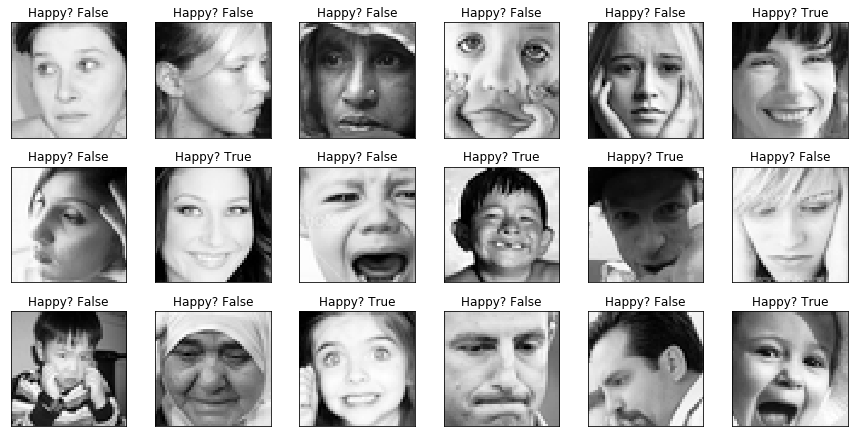

In [6]:
fig = plt.figure(1, (15., 8.))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 6), axes_pad=0.4)

for i in range(18):
    grid[i].imshow(train_images[i][:,:,0], cmap='gray')
    grid[i].set_title('Happy? ' + str(train_labels.isHappy.tolist()[i] == 1))
    grid[i].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    grid[i].tick_params(axis='y', which='both', left='off', labelleft='off')

In [7]:
train_examples = train_images.shape[0]
dims = train_images.shape[1:]
print('There are', train_examples, 'training images.')
print('With a size of', dims, 'pixels.')

There are 9000 training images.
With a size of (48, 48, 1) pixels.


### Make a small neural network 

In [8]:
model = Sequential()
model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=dims))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))

model.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 16)        592       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 32)          4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 64)          18496     
__________

In [10]:
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [11]:
history = model.fit(train_images, 
                    to_categorical(train_labels.isHappy.tolist()),
                    batch_size=32,
                    epochs=50,
                    validation_split=0.2,
                    shuffle=True)

Train on 7200 samples, validate on 1800 samples
Epoch 1/50
7200/7200 [==============================] - 68s - loss: 0.6794 - acc: 0.5578 - val_loss: 0.6517 - val_acc: 0.6106
Epoch 2/50
7200/7200 [==============================] - 1s - loss: 0.6100 - acc: 0.6712 - val_loss: 0.5785 - val_acc: 0.6972
Epoch 3/50
7200/7200 [==============================] - 1s - loss: 0.5674 - acc: 0.7106 - val_loss: 0.5557 - val_acc: 0.7200
Epoch 4/50
7200/7200 [==============================] - 1s - loss: 0.5350 - acc: 0.7361 - val_loss: 0.5408 - val_acc: 0.7372
Epoch 5/50
7200/7200 [==============================] - 1s - loss: 0.5104 - acc: 0.7525 - val_loss: 0.5230 - val_acc: 0.7400
Epoch 6/50
7200/7200 [==============================] - 1s - loss: 0.4933 - acc: 0.7560 - val_loss: 0.5007 - val_acc: 0.7511
Epoch 7/50
7200/7200 [==============================] - 1s - loss: 0.4739 - acc: 0.7736 - val_loss: 0.4981 - val_acc: 0.7544
Epoch 8/50
7200/7200 [==============================] - 1s - loss: 0.4556 - 

#### We can see that the train set is overfitted (almost 100% accuracy) and the validation set has about 80% accuracy.  
#### To make it more clear let's see the plotted accuracies and losses!

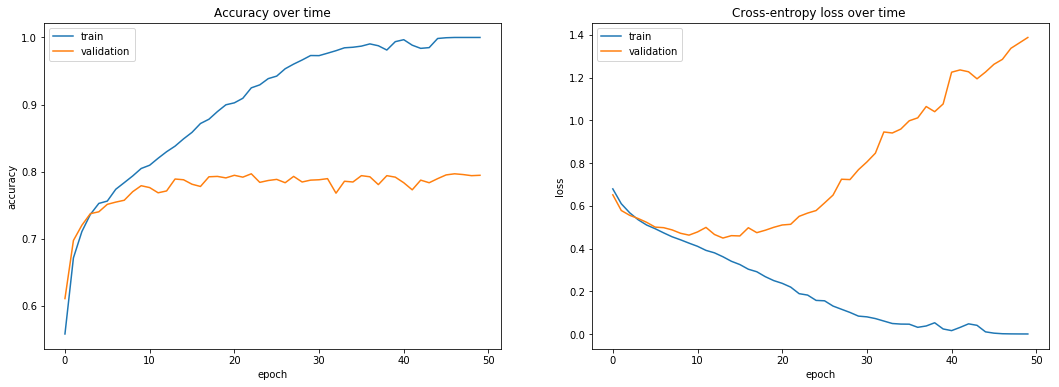

In [27]:
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('Accuracy over time')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Cross-entropy loss over time ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

#### The optimal stop point would be around 10-20 epochs. After that validation loss increases, but accuracy is saturated.

In [13]:
test_submission['isHappy'] = [int(i) for i in (model.predict(test_images)[:,1] > 0.5)] 
# if happiness probability >0.5, it is happy
test_submission.head(10)

,ID,isHappy
0,9001,1
1,9002,1
2,9003,1
3,9004,1
4,9005,0
5,9006,0
6,9007,1
7,9008,1
8,9009,0
9,9010,0


In [28]:
test_submission.to_csv('starter_submission.csv', index=False)

After uploading the **starter_submission.csv** we got a near 0.8 score!

### Your task is to make a neural network that produces better predictions.